In [1]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Batch

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [4]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="<IBM_TOKEN_HERE>", set_as_default=True)
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

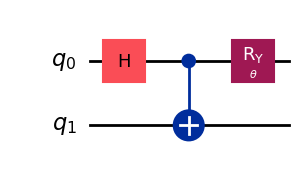

In [5]:
theta = Parameter("$\\theta$")

chsh_circuit_no_meas = QuantumCircuit(2)
chsh_circuit_no_meas.h(0)
chsh_circuit_no_meas.cx(0, 1)
chsh_circuit_no_meas.ry(theta, 0)
chsh_circuit_no_meas.draw(output="mpl", idle_wires=False, style="iqp")

In [6]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

In [7]:
ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])
XX = SparsePauliOp.from_list([("XX", 1)])

ops = [ZZ, ZX, XZ, XX]
num_ops = len(ops)

In [8]:
batch_circuits = [chsh_circuit_no_meas] * number_of_phases * num_ops
batch_ops = [op for op in ops for _ in individual_phases]

In [9]:
with Batch(backend=backend) as batch:
    estimator = Estimator()

    batch_expvals = (
        estimator.run(
            batch_circuits, batch_ops, parameter_values=individual_phases * num_ops, shots=10000
        )
        .result()
        .values
    )

In [10]:
ZZ_expval, ZX_expval, XZ_expval, XX_expval = [
    batch_expvals[kk * number_of_phases : (kk + 1) * number_of_phases] for kk in range(num_ops)
]

In [11]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab>
chsh1_est = ZZ_expval - ZX_expval + XZ_expval + XX_expval

# <CHSH2> = <AB> + <Ab> - <aB> + <ab>
chsh2_est = ZZ_expval + ZX_expval - XZ_expval + XX_expval

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\mikae\AppData\Local\Temp\ipykernel_2468\4101275803.py:18: SyntaxWarning: invalid escape sequence '\p'
  ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))


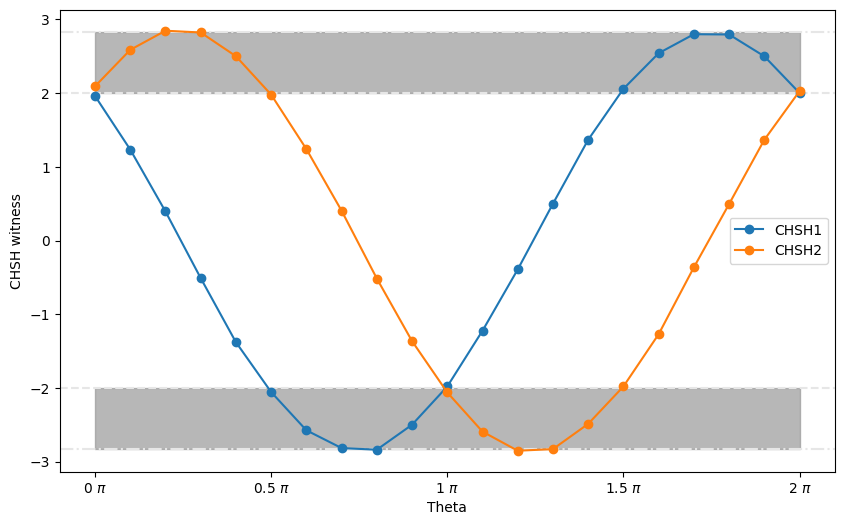

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()